# Extra 4 SQL Tricks Every Data Scientist Should Know

## Part 2 of Getting More Out of SQL to Step Up Your Analytics Work

In [1]:
from IPython.core.display import HTML
HTML("""
<style>

div.text_cell_render { /* Customize text cells */
font-size:1.3em;
line-height:1.4em;
}

</style>
""")

In my previous blog, <a href="https://resources.oreilly.com/binderhub/sql-functions-every-data-scientist-should-know">6 SQL Tricks Every Data Scientist Should Know</a>, I discussed the most useful SQL functionalities in my daily work as a data scientist. In this blog, Part 2 of this mini-series, I will continue to share my SQL tips to help you level up your analytics/reporting efficiency.

Today, we will be working with a new toy table, shown below, containing multiple data types. For demonstration purposes, this exercise will be implemented in MS SQL server 2017:

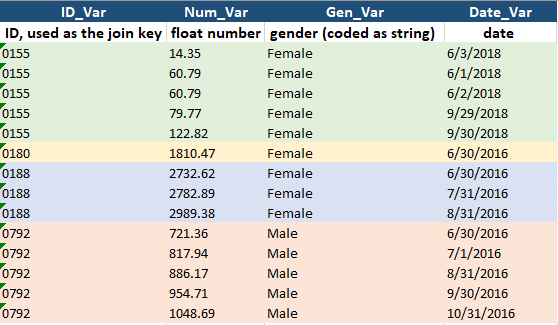

### 1. ROW_NUMBER() to Return a Subset of Rows

The `ROW_NUMBER()` function in SQL creates a unique incrementing integer value to each row of the result. This column of values is considered a **pseudo-column** as it does not inherently exist in our data table. Because of this, the result is returned in the order determined by the analysts in the `ORDER BY` clause.

With this pseudo-column, we can solve the "top N" questions using a simple query, and the following demonstrates how to select the top 3 records with the highest `Num_Var` value for each ID:

```mysql
/** 1). ROW_NUMBER() to select the top 3 **/
SELECT 
  rownumber, 
  id_var, 
  num_var
FROM 
(
  SELECT 
    ROW_NUMBER() OVER (PARTITION BY id_var ORDER BY num_var DESC) AS rownumber, 
    tab.*
  FROM cur_table			tab	
)	dat
WHERE rownumber <= 3
ORDER BY id_var, rownumber
```

Here is the returned subset (and of course, you can remove the column `RowNumber` from the output):

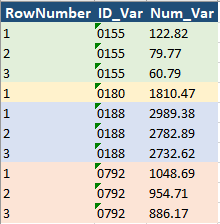

Notice that in spite of being only one row, ID 0180 was returned correctly just as other IDs (with more than 3 rows). Hence, no extra caution needed in regard to whether the raw data have enough rows for the number N specified. Straightforward!

### 2. Compute the Length of Consecutive Days with the `ROW_NUMBER()` (Advanced)

Knowing the concept of the `ROW_NUMBER()`, you must be thinking about another possible application in time series, where we calculate the consecutive time the event of interest lasts.

What do I mean? Well, let's consider our toy data as being customers logging in to our website. Customer ID 0155 logged in on 06/01, 06/02, and 06/03 (i.e., three consecutive days), and then there were another two consecutive logins on 09/29 and 09/30 each. Visually it is not that simple for us to do this calculation if the dates are not sorted. How could a SQL query help?

An intuitive way would be to first use the `ROW_NUMBER()` to assign row numbers ordered by dates within each customer ID. Because the integer row numbers happen to be incremental by 1, the length of consecutive days is just the difference between the last date and the first date! Unfortunately, it won't work because it would give us a 5, rather than 3 and 2 (for customer 0155).

This brings up an important note on the `ROW_NUMBER()` function: **it has no gaps!** It creates an ever-increasing value that always starts with 1 for each partition, whereas our data has gaps (e.g., 06/03 and 09/29 are not consecutive). Thus, simply applying `ROW_NUMBER()` cannot get us the desired output. We need some tweaks, and here's how:

***Step 1:*** Create the `RowNumber` (order by date ASC):

```mysql 
SELECT  
  dat.*, 
  ROW_NUMBER() OVER (PARTITION BY id_var ORDER BY date_var) AS rownumber
FROM 
  cur_table			dat
```

which gives us this interim output. Let's label it ***output_table_with_RowNumber*** for easy reference below:

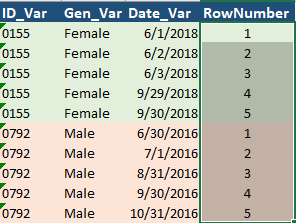

***Step 2:*** `Date_Var` − `RowNumber` to group the consecutive days (i.e., dates with the same starting points for counting):

```mysql 
SELECT	
  dat2.*, 
  DATEADD(DAY, -1*rownumber, date_var) AS starting_count_dt
FROM 
  (
    output_table_with_RowNumber
  ) dat2
```

and here's the return, which is labeled as ***output_table_with_grouping_var***:

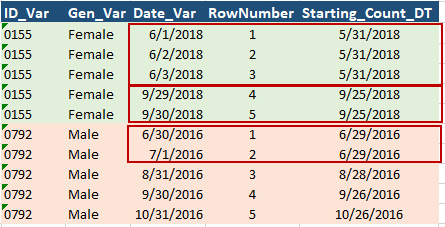

Don't get hung up on the values of this derived variable ***Starting_Count_DT*** because it's meaningless. It is just a grouping variable to tell SQL that these rows are consecutive (i.e., incremental by 1).

***Step 3:*** Calculate the length (of consecutive days) grouped by the `Starting_Count_DT`:

```mysql 
SELECT 
  id_var, 
  gen_var,
  MIN(date_var) AS start_dt,	
  MAX(date_var) as end_dt, 
  DATEDIFF(day, MIN(date_var), MAX(date_var))+1 AS consecutive_length
FROM
(
  output_table_with_grouping_var
) 
GROUP BY id_var, gen_var, starting_count_dt
ORDER BY id_var, start_dt
```

There is our final output!

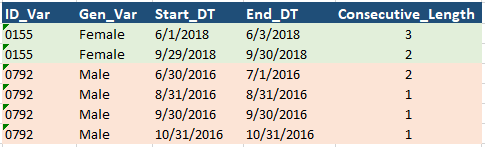

To put everything together:

```mysql 
/** 2) Compute the length of consecutive days **/
SELECT 
  id_var, 
  gen_var,
  MIN(date_var) AS start_dt,	
  MAX(date_var) as end_dt, 
  DATEDIFF(day, MIN(date_var), MAX(date_var))+1 AS consecutive_length
  /** Use the following if working in other databases, e.g., Orace, Netezza**/
  -- MAX(new_dat_var) - MIN(new_dat_var) + 1 AS cur_length
FROM
(
  SELECT	
    dat2.*, 
    DATEADD(DAY, -1*rownumber, date_var) AS starting_count_dt
  FROM 
  (
    SELECT  
      dat.*, 
      ROW_NUMBER() OVER (PARTITION BY id_var ORDER BY date_var) AS rownumber
    FROM 
      cur_table			  dat
  ) dat2
) dat3
GROUP BY id_var, gen_var, starting_count_dt
ORDER BY id_var, start_dt
```

Phew, problem solved! If you don't get it the first time, no worries, you can add this to your data science code snippets, and refer back whenever you need to. Spoiler alert: don't be surprised if you encounter this exact problem in your next interview for a data scientist position with the big tech companies! 😄

### 3. WITH Statement to Keep it DRY

The previous query, as we just saw, is a fairly complex one containing two nested sub-queries. These sub-queries add more complexity to read and debug our code in the sense that if we were to pass it to other teammates, chances are they would have no idea what this query is doing.

Now, the `WITH` clause (a.k.a., subquery factoring) to the rescue! Let's see how we can re-write the query above to make it more understandable:

```mysql 
/** 3) WITH statement to break down complex queries **/
WITH 
  output_table_with_RowNumber AS (
    SELECT  
      dat.*, 
      ROW_NUMBER() OVER (PARTITION BY id_var ORDER BY date_var) AS rownumber
    FROM 
      cur_table                         dat
  ), 
	
  output_table_with_grouping_var AS (
    SELECT 
      dat.*, 
      DATEADD(DAY, -1*rownumber, date_var) AS starting_count_dt
    FROM output_table_with_RowNumber    dat
  )
SELECT 
  id_var, 
  gen_var,
  MIN(date_var) AS start_dt,	
  MAX(date_var) as end_dt, 
  DATEDIFF(day, MIN(date_var), MAX(date_var))+1 AS consecutive_length
FROM
  output_table_with_grouping_var 
GROUP BY id_var, gen_var, starting_count_dt
ORDER BY id_var, start_dt
```

Here, (1) by leveraging the `WITH` clause, we broke down the nested queries into two individual temp views for better code readability; (2) there's no requirement for the relations among the multiple `WITH` queries, meaning that they can be independent or dependent (like in our example).

Another useful scenario for the `WITH` clause is when the `WITH` query is referenced multiple times. Without repeatedly writing the same sub-query again and again (i.e., <a href="https://en.wikipedia.org/wiki/Don't_repeat_yourself">the DRY / Don't Repeat Yourself principle</a>), we can introduce it upfront and reuse it later.

### 4. Concatenating to Re-format Your Data Structure

Moving on, our next task is to create an aggregated report for our internal stakeholders, showing the dates each customer logged in. This will be an aggregation of many-to-many information. Also, observe that the `ID_Var` and `Gen_Var` both contain duplicated values across rows. Therefore, to make it suitable for human reading, we immediately think of the `STRING_AGG()` function in MS SQL 2017:

```mysql 
/** 4) Aggregated report **/
SELECT
  id_var,
  gen_var,
  /** concatenated with comma in-between **/ 
  STRING_AGG(date_var, ',') WITHIN GROUP (ORDER BY date_var) AS concat_dates
  /** also works for the num_var **/
  -- STRING_AGG(num_var, ',') WITHIN GROUP (ORDER BY date_var) AS concat_nums
FROM
  cur_table
GROUP BY id_var, gen_var
ORDER BY id_var
```

This code snippet yields:

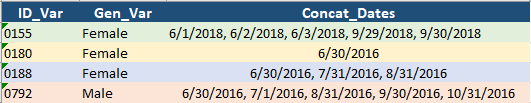

As we can see, (1) ordering the elements in the concatenated list is allowed by simply specifying the `ORDER BY` statement (e.g., ID 0155); (2) despite it being more commonly used for string concatenation, the `STRING_AGG()` function also works for other data types (e.g., the date and number variables in our example).

Now, a couple of ***callouts*** regarding this aggregation functionality:

(1) Although it is available in major SQL databases, the specific function name varies. In Oracle/PLSQL (11g), it's the **LISTAGG()**, in MySQL along with IBM Netezza, it's the **GROUP_CONCAT()**, in MS SQL server 2017 and PostgresSQL, it's the **STRING_AGG()**.

(2) Besides making the data view simpler, I also find it useful in scenarios where we need to pull data into R or Python for in-depth analysis (by the way, check out <a href="https://resources.oreilly.com/binderhub/sql-functions-every-data-scientist-should-know">my previous post for tips of extracting data from SQL database to Python</a> if you haven't done so). Instead of transferring the entire raw data table as is with most columns having duplicates, we can first concatenate the field with varying values into *one row per ID* to reduce the data size and then parse this field in R or Python. In this concatenation, `Null` values will be excluded, and thus, we don't have to worry about missing value handling at this point.

So there you have it—four additional SQL tips for data analytics! I hope you find this mini-series inspiring, and enjoyed reading it as much as I enjoyed writing it. As always, all the code snippets together with the toy data is available <a href="https://resources.oreilly.com/binderhub/sql-functions-every-data-scientist-should-know">here in this repo.</a> 😀